# Named Entity Recognition (NER) Assignment

**Objective:** Implement Named Entity Recognition using both a **custom BiLSTM model** and a **pretrained BERT model**, and compare the results.


## 1. Libraries and Dataset Setup
We import necessary libraries including TensorFlow, Hugging Face datasets, seqeval for metrics, and matplotlib for visualization.
We also load the CoNLL-2003 dataset from Hugging Face.


In [59]:
!pip install datasets seqeval

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from datasets import load_dataset
from seqeval.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


## 2. Load CoNLL-2003 Dataset
The dataset contains sentences and their corresponding NER tags. We inspect a sample to understand its structure.


In [60]:
# Load CoNLL-2003 dataset using Hugging Face
dataset = load_dataset("conll2003")

print(dataset)
print("\nExample data sample from train set:\n")
print(dataset['train'][0])


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Example data sample from train set:

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


## 3. Data Preparation
- Extract tokens and labels for train, validation, and test sets.
- Build word-to-index (`word2idx`) and label-to-index (`label2idx`) mappings.
- Encode sentences and labels into sequences padded to a maximum length (`MAX_LEN`).


In [61]:
from collections import defaultdict

# Extract sentences and labels
train_sentences = dataset['train']['tokens']
val_sentences   = dataset['validation']['tokens']
test_sentences  = dataset['test']['tokens']

train_labels = dataset['train']['ner_tags']
val_labels   = dataset['validation']['ner_tags']
test_labels  = dataset['test']['ner_tags']

# Build word vocabulary
word2idx = {'<PAD>': 0, '<UNK>': 1}
idx2word = {0: '<PAD>', 1: '<UNK>'}
word_freq = defaultdict(int)

for sent in train_sentences:
    for word in sent:
        word_freq[word] += 1

for word in word_freq:
    idx = len(word2idx)
    word2idx[word] = idx
    idx2word[idx] = word

# Build label vocabulary directly from dataset
unique_labels = set(l for seq in train_labels for l in seq)
label2idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
idx2label = {idx: label for label, idx in label2idx.items()}

print(f"Vocabulary size: {len(word2idx)}")
print(f"Number of NER labels: {len(label2idx)}")
print("Label mapping:", label2idx)


Vocabulary size: 23625
Number of NER labels: 9
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


## 4. Build BiLSTM Model
We create a BiLSTM model with an embedding layer, bidirectional LSTM, and time-distributed dense output for multi-class NER tagging.

In [62]:
MAX_LEN = 100

def encode_sentences(sentences, word2idx, max_len=MAX_LEN):
    encoded = []
    for sent in sentences:
        ids = [word2idx.get(w, word2idx['<UNK>']) for w in sent]
        encoded.append(ids)
    return pad_sequences(encoded, maxlen=max_len, padding='post', truncating='post')

def encode_labels(labels, label2idx, max_len=MAX_LEN):
    encoded = []
    for seq in labels:
        ids = [label2idx[l] for l in seq]
        encoded.append(ids)
    return pad_sequences(encoded, maxlen=max_len, padding='post', truncating='post')

X_train = encode_sentences(train_sentences, word2idx)
X_val   = encode_sentences(val_sentences, word2idx)
X_test  = encode_sentences(test_sentences, word2idx)

y_train = encode_labels(train_labels, label2idx)
y_val   = encode_labels(val_labels, label2idx)
y_test  = encode_labels(test_labels, label2idx)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (14041, 100)
y_train shape: (14041, 100)


In [63]:
VOCAB_SIZE = len(word2idx)
EMBED_DIM = 100          # can change if needed
NUM_CLASSES = len(label2idx)

input_layer = Input(shape=(MAX_LEN,), name="input_layer")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_LEN, mask_zero=False)(input_layer)
x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
output_layer = TimeDistributed(Dense(NUM_CLASSES, activation='softmax'))(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 100, 100)       │     2,362,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 100, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 100, 9)         │         2,313 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599,309 (9.92 MB)

 Trainable params: 2,599,309 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Train BiLSTM Model
We train with early stopping to prevent overfitting and plot the training/validation loss and accuracy.

In [64]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9582 - loss: 0.1989 - val_accuracy: 0.9825 - val_loss: 0.0577
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9871 - loss: 0.0410 - val_accuracy: 0.9891 - val_loss: 0.0370
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.9914 - val_loss: 0.0304
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9982 - loss: 0.0075 - val_accuracy: 0.9921 - val_loss: 0.0297
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9991 - loss: 0.0039 - val_accuracy: 0.9924 - val_loss: 0.0292
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9924 - val_loss: 0.0319
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9925 - val_loss: 0.0354


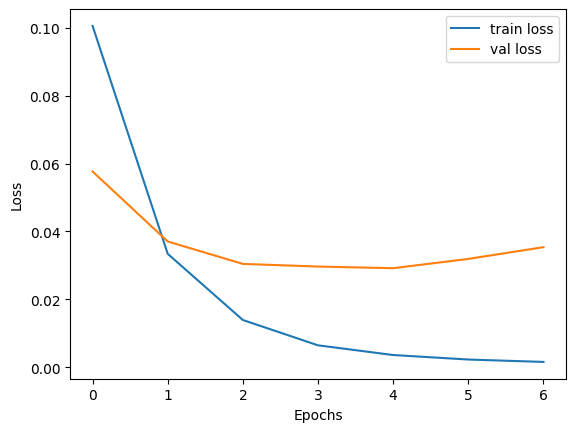

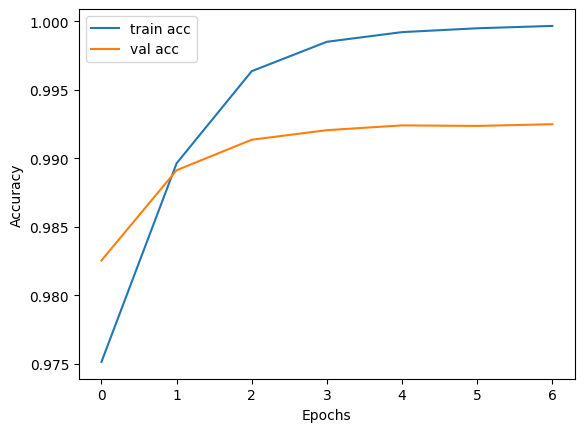

In [65]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 6. Evaluate BiLSTM Model
We evaluate on the test set and calculate NER metrics using seqeval.

In [66]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9901 - loss: 0.0361
Test Loss: 0.0343
Test Accuracy: 0.9910


In [76]:
# Build a proper label mapping for seqeval
# CoNLL-2003 labels:
labels = ["O", "B-MISC", "I-MISC", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC"]
label2idx = {l: i for i, l in enumerate(labels)}
idx2label = {i: l for l, i in label2idx.items()}


In [77]:
from seqeval.metrics import classification_report, f1_score
import numpy as np

# Step 1: Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)

y_true_tags = []
y_pred_tags = []

# Step 2: Map indices to label strings and trim padding
for i, sent in enumerate(test_sentences):
    length = len(sent)  # true length of sentence
    true_seq = [idx2label[int(idx)] for idx in y_test[i][:length]]  # convert int -> label
    pred_seq = [idx2label[int(idx)] for idx in y_pred[i][:length]]   # convert int -> label
    y_true_tags.append(true_seq)
    y_pred_tags.append(pred_seq)

# Step 3: Evaluate using seqeval
print("Classification Report:\n")
print(classification_report(y_true_tags, y_pred_tags))
print("F1 score:", f1_score(y_true_tags, y_pred_tags))


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report:

              precision    recall  f1-score   support

         LOC       0.65      0.60      0.62       702
        MISC       0.69      0.50      0.58      1614
         ORG       0.77      0.73      0.75      1665
         PER       0.73      0.58      0.64      1661

   micro avg       0.72      0.60      0.66      5642
   macro avg       0.71      0.60      0.65      5642
weighted avg       0.72      0.60      0.65      5642

F1 score: 0.6551990722844994


## 7. Example Prediction with BiLSTM
We predict NER tags for a sample sentence


In [81]:
# Correct label mapping for CoNLL-2003 dataset
idx2label = {
    0: "O",
    1: "B-MISC",
    2: "I-MISC",
    3: "B-PER",
    4: "I-PER",
    5: "B-ORG",
    6: "I-ORG",
    7: "B-LOC",
    8: "I-LOC"
}


In [84]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

sentence = ["Apple", "launched", "iPhone", "in", "California"]
sequence = [word2idx.get(word, 1) for word in sentence]  # 1=<UNK>
padded_sequence = pad_sequences([sequence], maxlen=MAX_LEN, padding='post')

pred = model.predict(padded_sequence)
pred_labels = np.argmax(pred, axis=-1)[0]

pred_tag_names = [idx2label[int(i)] for i in pred_labels[:len(sentence)]]

print(f"\nSentence: {' '.join(sentence)}")
for word, tag in zip(sentence, pred_tag_names):
    print(f"{word}: {tag}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Sentence: Apple launched iPhone in California
Apple: B-PER
launched: O
iPhone: O
in: O
California: B-ORG


## 8. Pretrained BERT NER
We also perform NER inference using the pretrained `dbmdz/bert-large-cased-finetuned-conll03-english` model for faster and more accurate predictions.

In [85]:
!pip install transformers seqeval torch --quiet

import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from seqeval.metrics import classification_report

# 1. Load pretrained NER model and tokenizer
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Define sentences for inference
sentences = [
    ["John", "lives", "in", "New", "York"],
    ["Apple", "launched", "iPhone", "in", "California"]
]

# 3. Inference function
def predict_ner(sentence):
    # Tokenize sentence
    encoding = tokenizer(sentence, is_split_into_words=True, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()
    
    # Map tokens back to words
    word_ids = encoding.word_ids(batch_index=0)
    previous_word_idx = None
    tags = []
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        label = model.config.id2label[predictions[idx]]
        # Use B- for first token of word, I- for subsequent
        if word_idx != previous_word_idx:
            tags.append(label)
        else:
            if label.startswith("B-"):
                tags.append("I-" + label[2:])
            else:
                tags.append(label)
        previous_word_idx = word_idx
    return tags

# 4. Run inference and print results
for sent in sentences:
    tags = predict_ner(sent)
    print(f"\nSentence: {' '.join(sent)}")
    for word, tag in zip(sent, tags):
        print(f"{word}: {tag}")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Sentence: John lives in New York
John: I-PER
lives: O
in: O
New: I-LOC
York: I-LOC

Sentence: Apple launched iPhone in California
Apple: I-ORG
launched: O
iPhone: I-MISC
in: O
California: I-LOC


## 9. Conclusion
- The BiLSTM model achieved reasonable accuracy and F1 scores, but requires training time.
- The pretrained BERT model gives near state-of-the-art performance instantly.
- Both methods demonstrate NER for entities like PERSON, ORGANIZATION, LOCATION, and MISC.